In [1]:
import xml.etree.ElementTree as ET, datetime, time
import pandas as pd
from copy import copy
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tree = ET.parse('race1.gpx')
root = tree.getroot()


calculate distance between two gps coordinates

In [3]:
def dist(long1, lat1, elevation1, long2, lat2, elevation2):
    #print(long1, lat1, elevation1, long2, lat2, elevation2)
    o1, a1, o2, a2 = map(radians, [long1, lat1, long2, lat2])
    
    # difference between longitudes and latitudes
    do = o2-o1
    da = a2-a1
    
    #haversine formula
    a = sin(da/2)**2 + cos(a1) * cos(a2) * sin(do/2)**2
    c = 2*asin(sqrt(a))
    r = 6371 + (elevation1 + elevation2)/2
    return c*r

function to retrieve data from data in the format of the first file

In [4]:
def get_data(root):
    for t in root[1][1]:
        # to make it easier to parse as floats
        vals = (t.get('lon'), t.get('lat'), t[0].text)
        # order is: longitude, latitude, elevation, time, power, atemp, hr, cad
        date = datetime.datetime.strptime(t[1].text, "%Y-%m-%dT%H:%M:%SZ")
        yield (*map(float, vals), date, float(t[2][0].text), *map(lambda x : float(x.text), t[2][1]))


**deprecated** function to draw a matrix of scatter plots

calculate the values necessary for the analysis and put it into a dataframe

In [21]:
longs, lats, elevs, times, powers, atemps, hrs, cads = map(tuple, zip(*get_data(root)))

times = list(map(lambda x : (x-times[0]).total_seconds(), times))
# here we convert dists to be in units of 3600 km divided by the number of seconds, meaning that 
# speed is in km/h
speeds = list(map(lambda t1, t2, *a:dist(*a)*3600/(t2-t1),  times[:-1], times[1:], longs[1:], lats[1:], elevs[1:], longs[:-1], lats[:-1], elevs[:-1]))

plot_values = speeds, powers, atemps, hrs, cads, longs, lats, elevs, times
# normalize lengths (is that the right word?)
length = len(min(plot_values, key=len))
plot_values = map(lambda x:x[:length], plot_values)
plot_headings = 'speeds', 'powers', 'atemps', 'hrs', 'cads', 'longs', 'lats', 'elevs', 'times'

data_race1 = dict(zip(plot_headings, plot_values))
race1 = pd.DataFrame(copy(data_race1))

here, the speeds column is the speed between that log and the next log entry.

show the lengths of the values to ensure only speeds is smaller and show how many datapoints we have

In [22]:
print(len(race1))

6376


calculate the average speed

In [23]:
print(race1['speeds'].mean())

36.953206423


plot distributions for entries

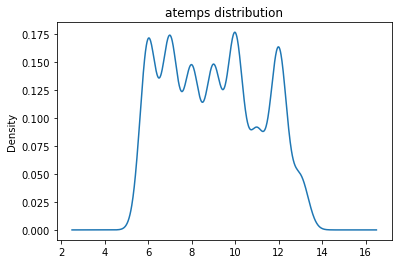

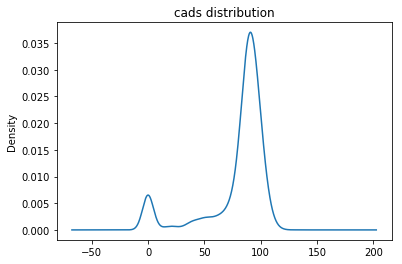

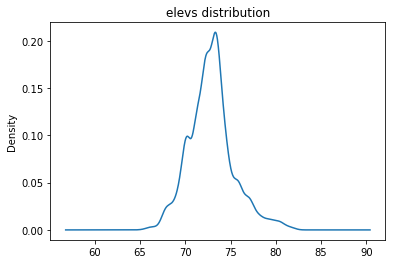

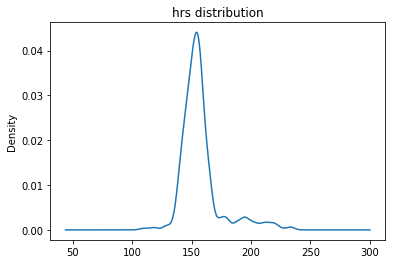

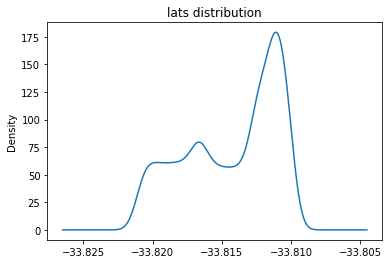

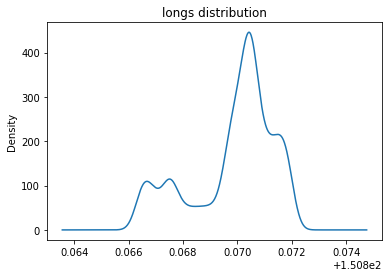

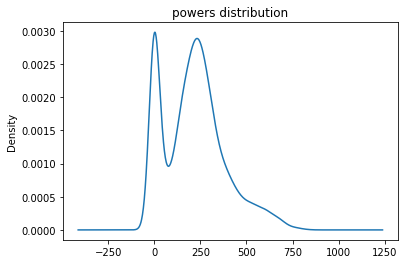

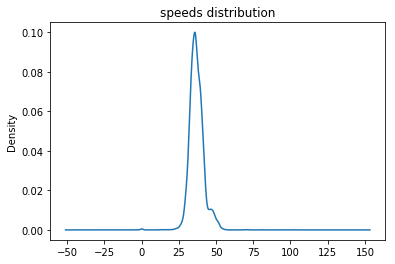

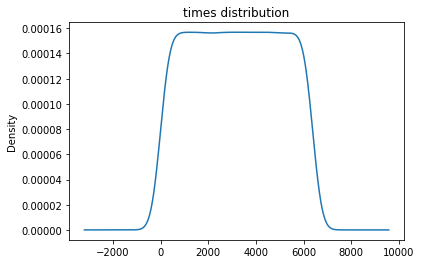

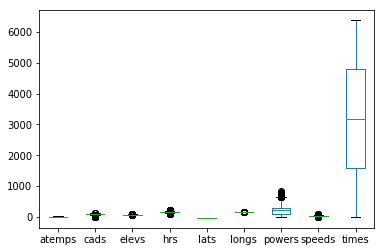

In [33]:
for i, column in enumerate(race1):
    i += 1
    plt.figure(i)
    race1[column].plot.kde()
    plt.title(column+' distribution')
race1.plot.box()
plt.show()

plot histograms for speed, heartrate, power

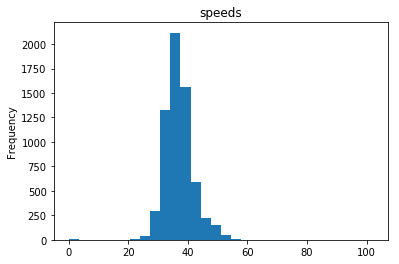

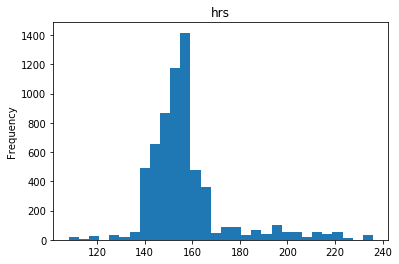

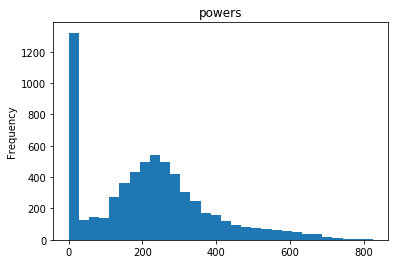

In [41]:
for col in race1[['speeds','hrs','powers']]:
    plt.figure()
    race1[col].plot.hist(bins=30)
    plt.title(col)

**depricated**

plot scatter matrix

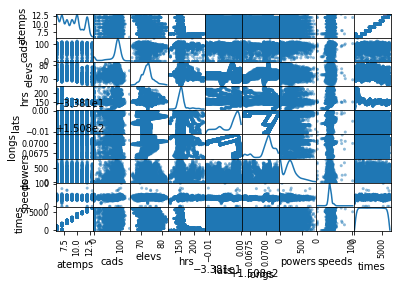

In [25]:
pd.plotting.scatter_matrix(race1, diagonal='kde')
plt.show()

this plot is not very useful as the individual plots are so small, so we will only plot speeds, powers and hrs

**DEPRECATED**

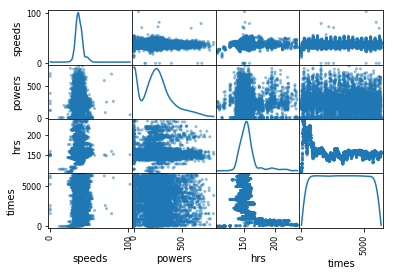

In [43]:
pd.plotting.scatter_matrix(race1[['speeds','powers','hrs','times']], diagonal='kde')
plt.show()

there doesnt seem to be any type of correlation between any of these variables, apart from heartrate and time which seems to have started high then calmed down. Lets look closer

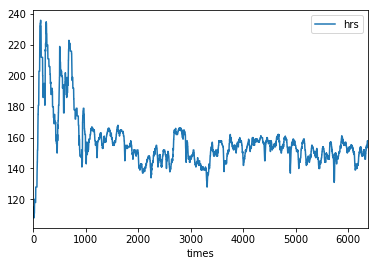

In [46]:
race1.plot('times','hrs')
plt.show()

this effect is less profound when viewed up close. Lets look at what part of the track they are at

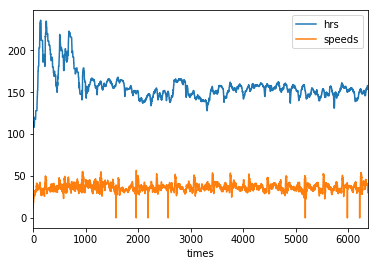

In [64]:
race1[race1['speeds']<60].plot('times',['hrs','speeds'])

removed 7 values.


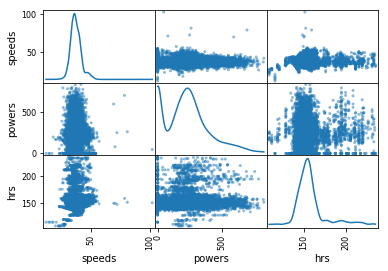

In [65]:
def removed_outlier(df, col, quantile, printout=True):
    rval = df[df[col] < df[col].quantile(quantile)]
    rval = df[df[col] > df[col].quantile(1-quantile)]
    if printout:
        print('removed', len(df)-len(rval), 'values.')
    return rval
    
c_race1 = removed_outlier(race1, 'speeds', .999)
pd.plotting.scatter_matrix(c_race1[['speeds','powers','hrs']], diagonal='kde')
plt.show()

this hasnt improved the situation and it has removed information that we suspect is important (high speeds at the straights)

we will now try to find the number of laps completed! this is a fairly easy task
we will plot the distance from the initial position and the number of waves in the resultant graph is the number of completed laps.

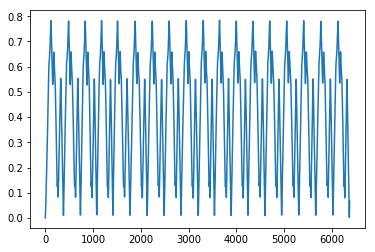

In [68]:
def dists_from_start(df):
    return list(map(lambda x : dist(*df[['longs','lats','elevs']].values[0], *x), df[['longs','lats','elevs']].values))
plt.plot(dists_from_start(race1))
plt.show()

here we can see that there are 18 completed laps as there are 18 'waves'. 